In [1]:
import os.path
import sqlite3
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from process_text import clean_up_text
from process_text import preprocess
from process_text import string_cohesion
from sklearn.feature_extraction.text import TfidfVectorizer

#conn = sqlite3.connect('location_based_database.db')
conn = sqlite3.connect('keyword_based_database.db')
#c = conn.cursor()
#c.execute('''SELECT * FROM tweet;''')

# Read into a Pandas Data Frame
df = pd.read_sql_query("SELECT * FROM tweet where tweet_text like '%Ford%' LIMIT 10000;",conn)

/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/javier/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **k

[nltk_data] Downloading package wordnet to /home/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/javier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---------------------------------------------------------
Column names: 
 ['tweet_id_text', 'tweet_hashtag', 'tweet_text', 'created_at', 'geo_lat', 'geo_long', 'user_id_text'] 

The number of tweets:  10000 

---------------------------------------------------------
0    It was June and I was going train station to c...
1    RT @ruthmkb: “I’ve been so loyal to the Fords,...
2    RT @JamesHMcLaren: Just heard on the radio For...
3    RT @jessewente: Doug Ford’s ‘North Korean’-Sty...
4    RT @Autotestdrivers: 2019 Ford Ranger Will Off...
5    RT @MSportLtd: There was a Model T Ford visit ...
6    2018 Tom Ford Aiden-02 FT-585 Men Gray Gold Me...
7    RT @erikawybourn: #Ward7 you can do better. Vo...
8    I’m pretty sure if Tyson beck ford cane or the...
9    RT @OutAndAbouter: Doug Ford Says If People Wa...
Name: tweet_text, dtype: object


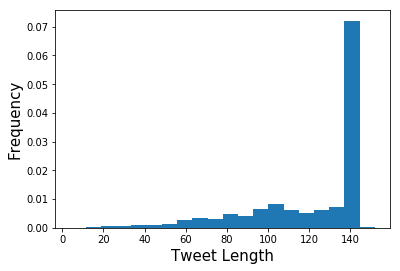

In [2]:
# Some simple Data exploration

N_raw_tweets = len(df)

print('---------------------------------------------------------')
print('Column names: \n', list(df.columns.values),"\n")
print('The number of tweets: ', N_raw_tweets,'\n')
print('---------------------------------------------------------')

# Show the First ten items in the tweet database
print(df['tweet_text'][0:10])



# A small data frame to plot the length of the tweets
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_raw.pdf',bboxes='tight')
plt.show()

Example text: 

@MargaretWatson7 @MitzieHunter @OntLiberal @TorontoStar Premier Ford is cutting the waste of the previous Liberal g… https://t.co/ahDpEMLdYT 

Processed text: 

premier ford cut waste previous liberal 



The number of tweets after removing duplicates:  5189 

Fraction removed:  0.481


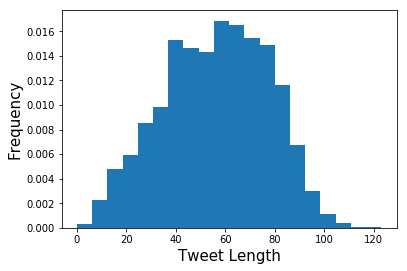

In [3]:
text = df['tweet_text'][80]

print('=============================================================')
print("Example text: \n")
print(text,'\n')
print("Processed text: \n")
print(clean_up_text(text),'\n')
print('=============================================================')

# Apply the 'Clean-up-text function to all tweets in the data frame'
df['tweet_text'] = df['tweet_text'].apply(clean_up_text)

#print('The size of the table: ', len(df),'\n')


# Remove duplicate tweets and reset the index
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)
df=df.reset_index(drop=True)

N_processed_tweets = len(df)

print('\n')
print('=============================================================')
print('The number of tweets after removing duplicates: ', N_processed_tweets ,'\n')
print('Fraction removed: ', round(1.0-(N_processed_tweets/float(N_raw_tweets)),3) )
print('=============================================================')

# A small data frame to plot the length of the tweets
df_len= df['tweet_text'].apply(len)
plt.hist(df_len,bins=20,density=True)
plt.ylabel('Frequency',size=15)
plt.xlabel('Tweet Length',size=15)
plt.savefig('tweet_length_histogram_processed.pdf',bboxes='tight')
plt.show()

In [4]:
# We create a snippet array and a raw document array to hold all of tweets

raw_documents = []
snippets = []

for k in range(0,len(df)):
    text = df['tweet_text'][k]
    raw_documents.append(text)
    snippets.append(text)

print("Read %d raw tweets documents" % len(raw_documents))

#We will load in the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )

# we pass processing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)

# Using the Tfidvectorizer we generate the document matrix
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Read 5189 raw tweets documents
Created 5189 X 364 TF-IDF-normalized document-term matrix
Vocabulary has 364 distinct terms


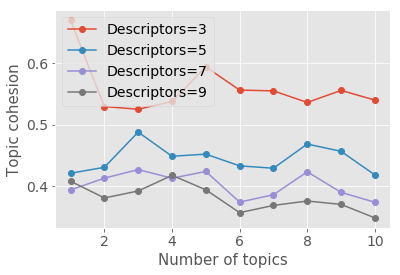

Optimal Topics:  3


In [13]:
from sklearn import decomposition
import scipy as sc


def get_descriptor( terms, H, topic_index, top ):
    '''
    This function can return the 
    
    H: 
    topic_index: integer, corresponds to the topic chosen
    top: The number of topics that will be returned
    terms: The words in the vocabulary
    '''
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    
    return top_terms


def topic_grid_search(A,N_descriptors,kmin=1,kmax=10):
    
    cohesion_array = []
    k_array = []
    
    for k in range(kmin,kmax+1):
        model = decomposition.LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
        W = model.fit_transform( A )
        H = model.components_
        N_topic_samples = []
        
        descriptors = []
        word_dict = {}
        topics_cohesion = 0.0
        
        for topic_index in range(k):
            s=get_descriptor( terms, H, topic_index, N_descriptors )
            
            # Concatenate the array of strings into a single string
            sk=' '.join(s)
            topics_cohesion+=string_cohesion(sk)
            descriptors.append(s)
            str_descriptor = ", ".join( descriptors[topic_index] )
            word_dict['Topic # ' + '{:02d}'.format(topic_index+1)] = [word for word in descriptors[topic_index]];
    
        ca = topics_cohesion/float(k)
        cohesion_array.append(ca)
        k_array.append(k)
    
    return k_array,cohesion_array

# Define some parameters 
N_descriptors = 7
cohesion_array = []
k_array = []

#for k in range(1,10):
 #   model = decomposition.LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
 #   W = model.fit_transform( A )
  #  H = model.components_
  #  N_topic_samples = []
    
#    descriptors = []
#    word_dict = {}
#    topics_cohesion = 0.0
    
#    for topic_index in range(k):
#        s=get_descriptor( terms, H, topic_index, N_descriptors )
        
        # Concatenate the array of strings into a single string
#        sk=' '.join(s)
#        topics_cohesion+=string_cohesion(sk)
        
#        descriptors.append(s)
#        str_descriptor = ", ".join( descriptors[topic_index] )
        #print(str_descriptor)
#        word_dict['Topic # ' + '{:02d}'.format(topic_index+1)] = [word for word in descriptors[topic_index]];
    
#    ca = topics_cohesion/float(k)
#    cohesion_array.append(ca)
#    k_array.append(k)
    #print('Number of topics: ', k,' Cohesion: ',ca,'\n')   
k_array,cohesion_array0 = topic_grid_search(A,N_descriptors=3,kmin=1,kmax=10)
k_array,cohesion_array = topic_grid_search(A,N_descriptors=5,kmin=1,kmax=10)
k_array,cohesion_array2 = topic_grid_search(A,N_descriptors=7,kmin=1,kmax=10)
k_array,cohesion_array3 = topic_grid_search(A,N_descriptors=9,kmin=1,kmax=10)

# Data Frame with Topic words
plt.plot(k_array,cohesion_array0,'-o',label='Descriptors=3')
plt.plot(k_array,cohesion_array,'-o',label='Descriptors=5')
plt.plot(k_array,cohesion_array2,'-o',label='Descriptors=7')
plt.plot(k_array,cohesion_array3,'-o',label='Descriptors=9')
plt.ylabel('Topic cohesion',size=15)
plt.xlabel('Number of topics', size=15)
plt.legend()
plt.savefig('topics_vs_cohesion_Ndescriptors_'+str(N_descriptors)+'.pdf',bboxes='tight')
plt.show()

# Fit the optimal number of topics 
k0 = k_array[np.argmax(cohesion_array)]
print('Optimal Topics: ', k0)

In [6]:
k = k0
model = decomposition.LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

descriptors = []
word_dict = {}

for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 20 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    word_dict['Topic # ' + '{:02d}'.format(topic_index+1)] = [word for word in descriptors[topic_index]];

# Data Frame with Topic words
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03
0,ford,ford,ford
1,now,new,doug
2,look,car,like
3,see,get,not
4,take,mustang,people
5,harrison,go,amp
6,focus,sale,think
7,city,tom,henry
8,great,gt,video
9,call,ebay,ontario


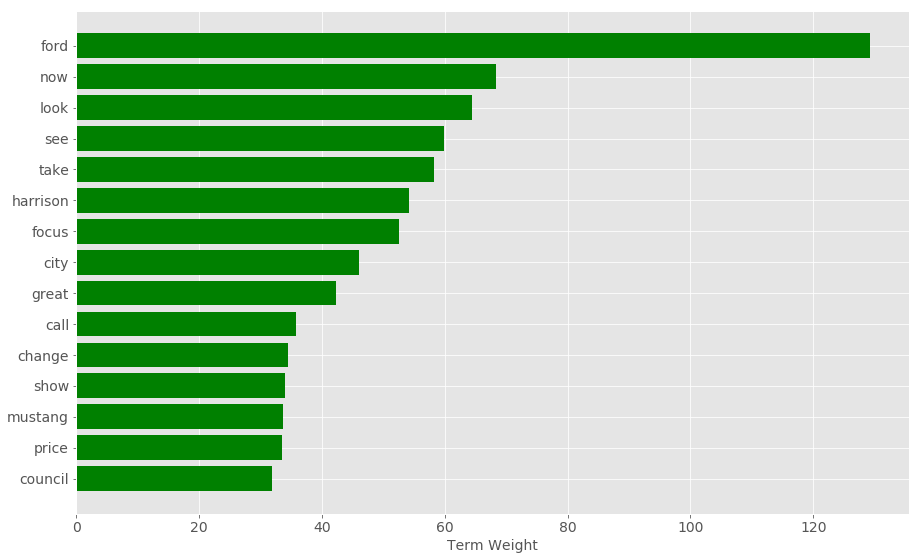


 Topic:  1
01. price change ford super duty take look 
02. price ford super duty now take look 
03. ford super duty now available take look 
04. council jacket wear harrison ford play han solo empire strike back expect fetch 
05. jacket wear harrison ford star war film empire strike back expect fetch mil 
06. jacket wear actor harrison ford star war film empire strike back expect fetch 
07. han solo jacket wear harrison ford star war film empire strike back could fetch 
08. cover half harrison ford face hand can see act different emotion htt 
09. cover half harrison ford face hand can see act different emotion 
10. now play osn movie action patriot game imdb star harrison ford anne archer k 



In [7]:
# Analysis using textblob
from textblob import TextBlob
import collections

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

def get_top_tweets( all_tweets, W, topic_index, top ):
    '''
    Returns the most relevant tweets ordered according to their topic relevance
    '''
    
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    
    # now get the snippets corresponding to the top-ranked indices
    top_tweets = []
    for doc_index in top_indices[0:top]:
        top_tweets.append( all_tweets[doc_index] )
    return top_tweets
    
    
    
topic = 0   
    
plot_top_term_weights( terms, H, topic, 15 )    


# Let us look now at the most relevant posts for each topic
topic_tweets = get_top_tweets( snippets, W, topic, 10 )

print('================================================')
print('\n Topic: ', topic+1)
for i, tweet in enumerate(topic_tweets):
    print("%02d. %s " % ( (i+1), tweet) )
print('================================================\n')

In [8]:
# Now that we have found the specific topics that we want to filter out, we must make a new data frame that removes
# the most relevant tweets in all of these categories.

# Enumerates the topics that we want to remove
drop_topics = [0]
drop_fraction = 0.3 # We will drop 40% of tweets ranked according to this category
drop_number = int(len(df)*drop_fraction)
drop_tweets = []

for drop_topic in drop_topics:
    topic_tweets = get_top_tweets( snippets, W, drop_topic, drop_number)
    drop_tweets+=topic_tweets   
    
# This command drops the rows that are in the selected topics
df = df[~df['tweet_text'].isin(drop_tweets)]
df=df.reset_index(drop=True)
N_dropped_topics = len(df)


print('=============================================================')
print("Number of processed tweets: ", N_processed_tweets)
print("Number of tweets after topic removal: ", N_dropped_topics)
print("Number of tweets removed: ", drop_number)
print('=============================================================')

Number of processed tweets:  5189
Number of tweets after topic removal:  3633
Number of tweets removed:  1556


In [9]:
# Now we can do an analysis on the final data